In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

In [52]:
class Naive_Bayes():
    def __init__(self, df, no_of_labels, col_name = "CoronaTweet"):
        self.df = df 
        self.no_of_labels = no_of_labels
        self.probabilities = dict()
        self.y_prob = [0] * self.no_of_labels
        self.log_probabilities, self.y_log_prob, self.set_of_words = dict(), [0] * self.no_of_labels , set()
        self.sets = [set()] * self.no_of_labels 
        self.frequencies = dict() 
        self.SIZE = 0 
        self.SIZES = [0] * self.no_of_labels
        self.col_name = col_name
    

    def preprocess(self, text):
        return text.split(" ") 

    def convert_to_feature(self):
        self.df["splitWords"] = (self.df[self.col_name]).apply(self.preprocess)

        
    
    
    def compute_freqs(self):
        self.SIZES = [0, 0, 0]

        for index, row in self.df.iterrows():
            if (row["Sentiment"] == "Positive"):
                row["Sentiment"] = 2
            elif (row["Sentiment"] == "Neutral"):
                row["Sentiment"] = 1
            else:
                row["Sentiment"] = 0
            i = row["Sentiment"] # i is class 
            for word in row["splitWords"]:
                    # if (word == "")  : continue
                    self.SIZES[i] += 1
                    if (word in self.set_of_words):
                        self.frequencies[word][i] += 1
                    else:
                        self.set_of_words.add(word)
                        self.frequencies[word] = [0] * self.no_of_labels
                        self.frequencies[word][i] += 1
                    self.sets[i].add(word)

        self.SIZE = len(self.set_of_words) 
    
    def compute_log_probs(self):

        for word in self.set_of_words:
            self.probabilities[word] = [0] * self.no_of_labels
            self.log_probabilities[word] = [0] * self.no_of_labels
            for i in range(self.no_of_labels):
                self.probabilities[word][i] = (self.frequencies[word][i] + 1) / (self.SIZES[i] + self.SIZE)
                self.log_probabilities[word][i] = math.log(self.probabilities[word][i])
        
        total_size = sum(self.SIZES)

        self.y_prob = [self.SIZES[i]/total_size for i in range(self.no_of_labels)]
        self.y_log_prob = [math.log(self.y_prob[i]) for i in range(self.no_of_labels)]
    
    def compute_canonical_log_prob(self, text, label): # ignores P(x) in P(y | x) = P(x|y) * P(y)/ P(x) 
        word_list = self.preprocess(text)
        log_prob = 0 
        for word in word_list:
            # if (word == "") : continue # ignore empty strings 
            if (word in self.set_of_words):
                log_prob += self.log_probabilities[word][label] 
            else:
                # log_prob -= math.log((SIZES[label] + SIZE))  # prob is 1 / (SIZES[label] + SIZE)
                continue 
        log_prob += self.y_log_prob[label] 
        return log_prob  
    
    def train(self):
        self.convert_to_feature() 
        self.compute_freqs()
        self.compute_log_probs() 
        print("training complete") 

    def predictor(self, text):
       
        log_probs = [self.compute_canonical_log_prob(text, i) for i in range(self.no_of_labels)] 
        max_prob = log_probs[0] 
        max_label = 0 

        for i in range(self.no_of_labels):
            if (log_probs[i] > max_prob):
                max_prob = log_probs[i]
                max_label = i
            elif (log_probs[i] == max_prob):
                max_label = max_label if (self.SIZES[max_label] > self.SIZES[i])  else i 
        return max_label
    
    

    def compute_accuracy(self, df ): # input is a dataframe
        correct = 0 
        for idx,rows in df.iterrows():
            prediction = self.predictor(rows[self.col_name]) 
            # print(f"{prediction} {rows['Sentiment']}")
            rows["Sentiment"] = 0 if (rows["Sentiment"] == "Negative") else 2 if (rows["Sentiment"] == "Positive") else 1
            if (prediction == rows["Sentiment"]):
                correct += 1
        return correct / len(df) 

    def compute_confusion_matrix(self, df):
        confusion_matrix = np.zeros((self.no_of_labels, self.no_of_labels)) 
        for idx,rows in df.iterrows():
            prediction = self.predictor(rows[self.col_name]) 
            # print(f"{prediction} {rows['Sentiment']}")
            rows["Sentiment"] = 0 if (rows["Sentiment"] == "Negative") else 2 if (rows["Sentiment"] == "Positive") else 1
            confusion_matrix[rows["Sentiment"]][prediction] += 1 
           
        return confusion_matrix



In [4]:
# Read in the data
df = pd.read_csv('../data/Corona_train.csv') 
print(df) 
no_of_labels = 3

          ID Sentiment                                        CoronaTweet
0      22979  Positive  I see all kinds of academics already whipping ...
1       9880  Negative  @HenrySmithUK can you raise with Boris please ...
2      35761  Negative  It s a confusing odd time for the shopping pub...
3      37968  Positive  Blog Summary: The Impact of COVID-19 on the Ca...
4      19709   Neutral  ??????? ??????? ???\r\r\nWaiting in a long Que...
...      ...       ...                                                ...
37859  20253   Neutral  DOUBLE TAP ??IF YOU REMEMBER BEING EMPLOYED?\r...
37860  38926  Positive  Struggling to understand why supermarkets or f...
37861  35889  Positive  For anyone interested in the checklist on cons...
37862  40641  Positive  Do you agree with the hypothesis that Indian s...
37863  26063   Neutral  In Richmond, local boutiques and thrift stores...

[37864 rows x 3 columns]


In [5]:
weak_classifier = Naive_Bayes(df, 3) 
weak_classifier.train() 
training_accuracy = weak_classifier.compute_accuracy(df)
print(training_accuracy)

training complete
0.8499630255651807


In [6]:
df_test = pd.read_csv('../data/Corona_validation.csv') 
test_accuracy = weak_classifier.compute_accuracy(df_test)
print(test_accuracy)

0.6601882781658063


In [7]:
# visualising with a word cloud
from wordcloud import  WordCloud, STOPWORDS
stopwords = set(STOPWORDS) 
# print(stopwords)

In [8]:

def get_wordcloud(name, database, max_words = 1000000):
    wc = WordCloud(background_color="white", max_words = max_words, stopwords=stopwords) 
    wc.generate(database) 

    wc.to_file(f"{name}.png")

    fig = plt.figure() 
    fig.set_figheight(18) 
    fig.set_figwidth(14) 
    
    plt.imshow(wc, interpolation='bilinear') 
    plt.axis("off")
    plt.show()


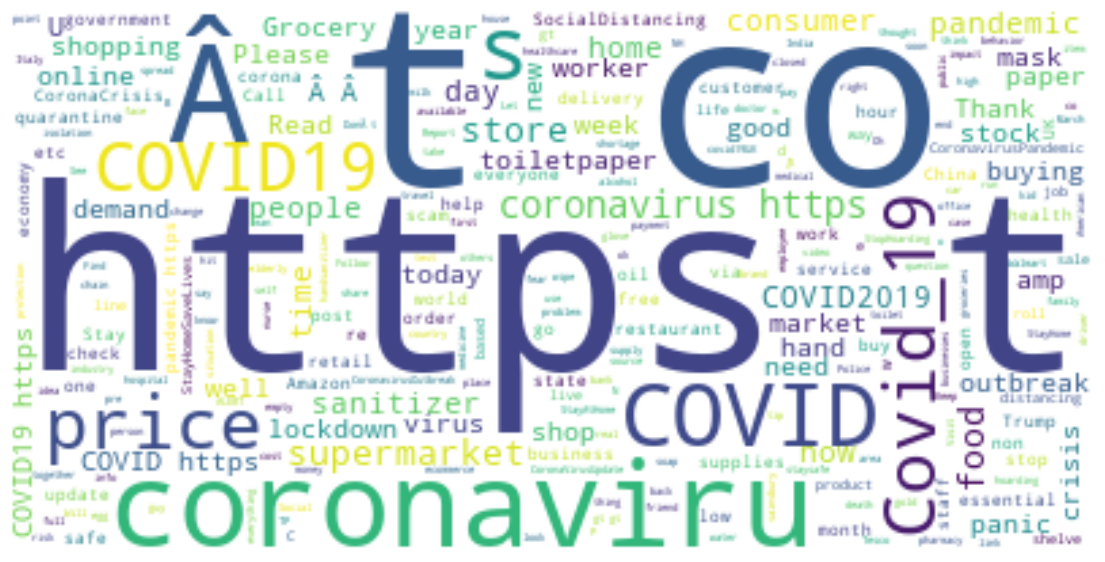

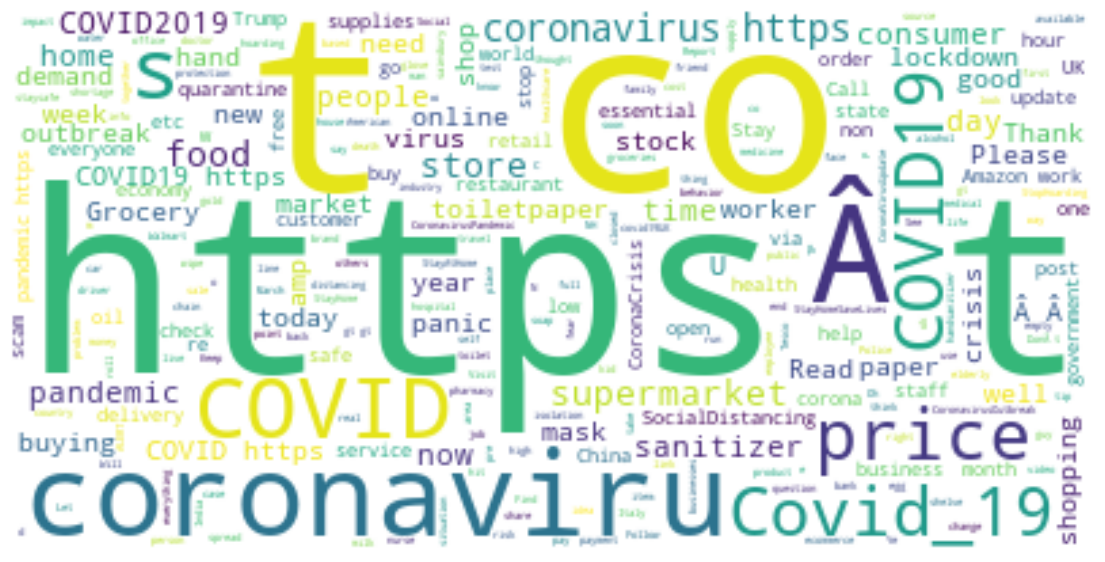

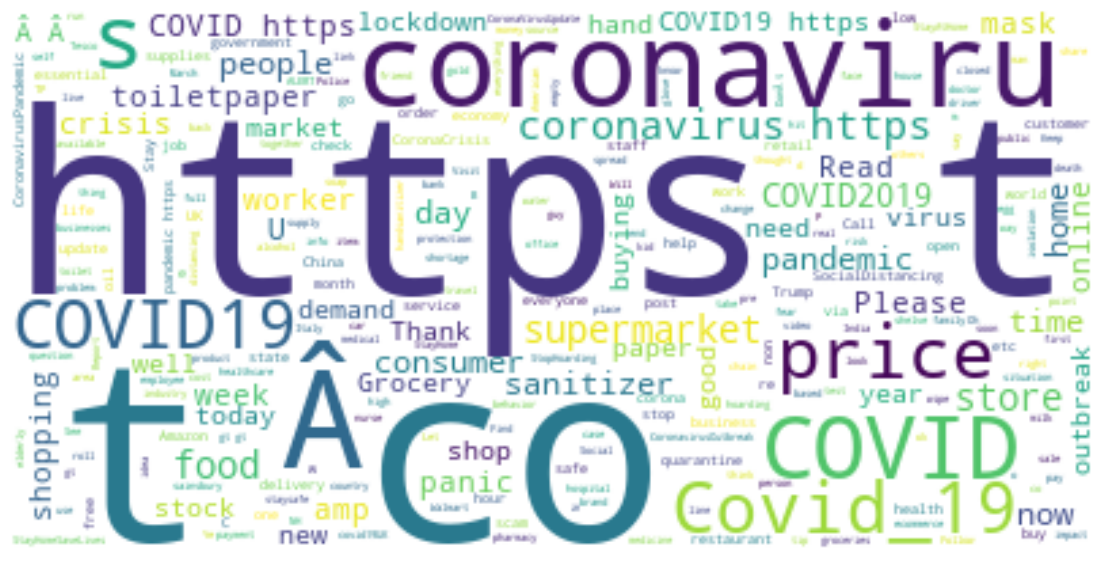

In [9]:

for i in range(no_of_labels):
    get_wordcloud(f"wordcloud_1_{i}", " ".join(weak_classifier.sets[i])) 

In [10]:
def random_predictor(text, no_of_labels):
    x = np.random.randint(0,no_of_labels) 
    # assert(x >= 0 and x < 3)
    return x 

In [11]:
def always_positive_predictor(text, no_of_labels): 
    return no_of_labels - 1 

In [12]:
def compute_random_predictor_accuracy(df, no_of_labels, confusion_matrix):
    correct  = 0 
    for idx,rows in df.iterrows():
        prediction = random_predictor(rows["CoronaTweet"], no_of_labels) 
        rows["Sentiment"] = 0 if (rows["Sentiment"] == "Negative") else 2 if (rows["Sentiment"] == "Positive") else 1
        confusion_matrix[rows["Sentiment"]][prediction] += 1 
        if (prediction == rows["Sentiment"]):
            correct += 1
    return correct / len(df)

In [13]:
def compute_allpositive_predictor_accuracy(df, no_of_labels, confusion_matrix):
    correct  = 0 
    for idx,rows in df.iterrows():
        prediction = always_positive_predictor(rows["CoronaTweet"], no_of_labels) 
        rows["Sentiment"] = 0 if (rows["Sentiment"] == "Negative") else 2 if (rows["Sentiment"] == "Positive") else 1
        confusion_matrix[rows["Sentiment"]][prediction] += 1 
        if (prediction == rows["Sentiment"]):
            correct += 1
    return correct / len(df)

In [14]:

def draw_confusion_matrix( confusion_matrix, name):
    
        correct = 0 
        total = 0 
        fig, ax = plt.subplots(figsize=(10,10))
        ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3) 
        max_diag = 0 
        max_diag_label = 0
        for i in range(confusion_matrix.shape[0]):
            for j in range(confusion_matrix.shape[1]):
                total += confusion_matrix[i,j]
                if (i == j) : 
                    correct += confusion_matrix[i,j]
                    if (max_diag < confusion_matrix[i,j]):
                        max_diag = confusion_matrix[i,j]
                        max_diag_label = i
    
                ax.text(x=j, y=i,s= confusion_matrix[i, j], va='center', ha='center', size='xx-large')
        
        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.savefig(f"confusion_matrix_{name}.png")
        # plt.show()
        print(f"accuracy is {correct/total}")
        print(f"label with max diagonal is {max_diag_label}")

accuracy is 0.8499630255651807
label with max diagonal is 2
accuracy is 0.6601882781658063
label with max diagonal is 2


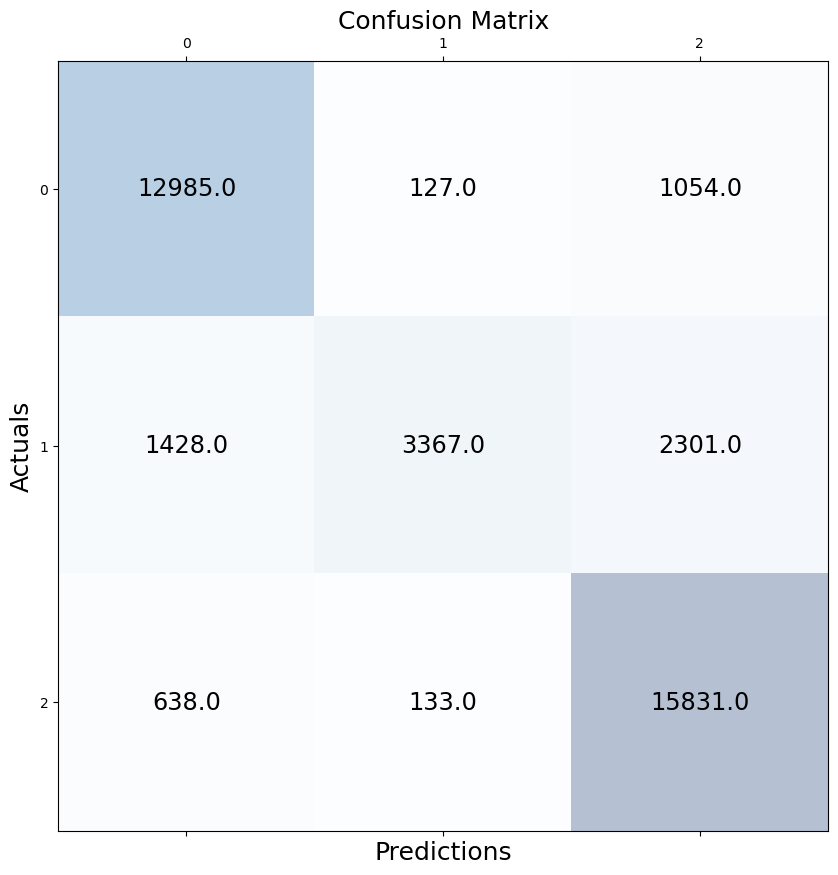

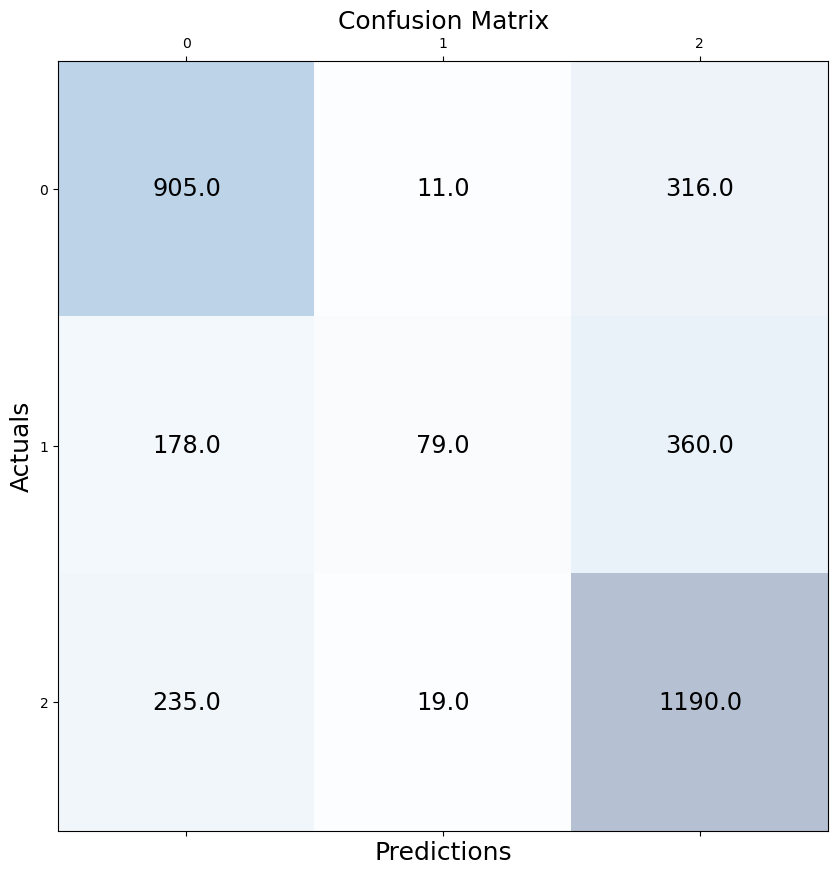

In [15]:
m1 = weak_classifier.compute_confusion_matrix(df)
m2 = weak_classifier.compute_confusion_matrix(df_test) 
draw_confusion_matrix(m1, "og_train")
draw_confusion_matrix(m2, "og_test")

accuracy is 0.32827209231703613
label with max diagonal is 2
accuracy is 0.4385059216519891
label with max diagonal is 2
accuracy is 0.33440735263046695
label with max diagonal is 2
accuracy is 0.4384639763363617
label with max diagonal is 2
0.32827209231703613
0.4385059216519891
improvement over random baseline is 0.33191618584877014
improvement over all positive baseline is 0.22168235651381718


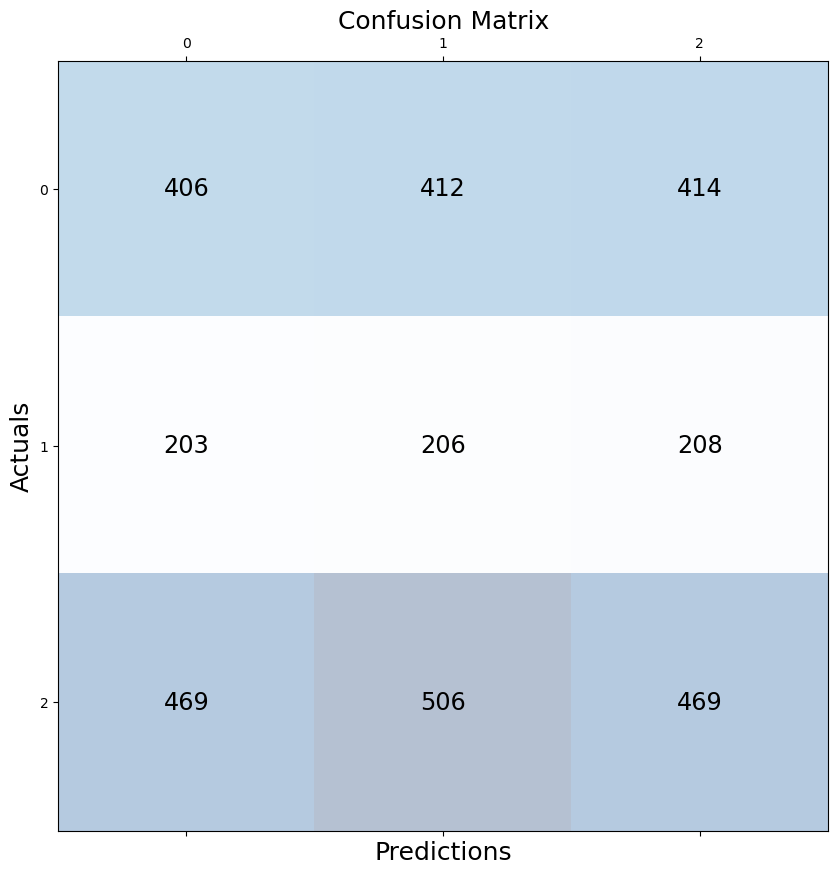

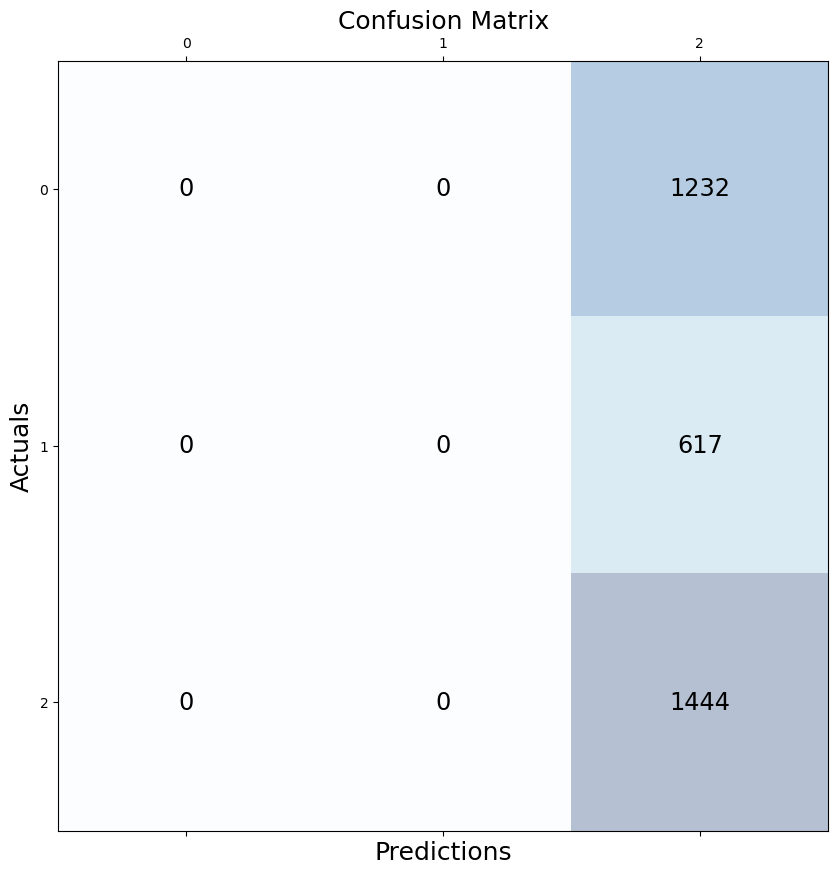

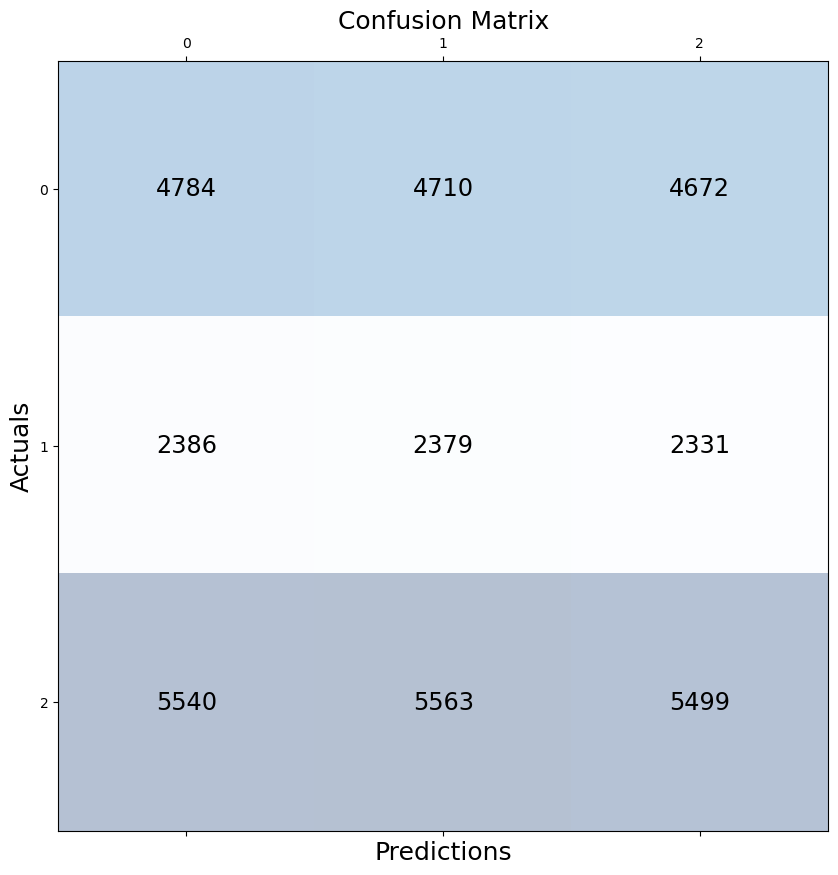

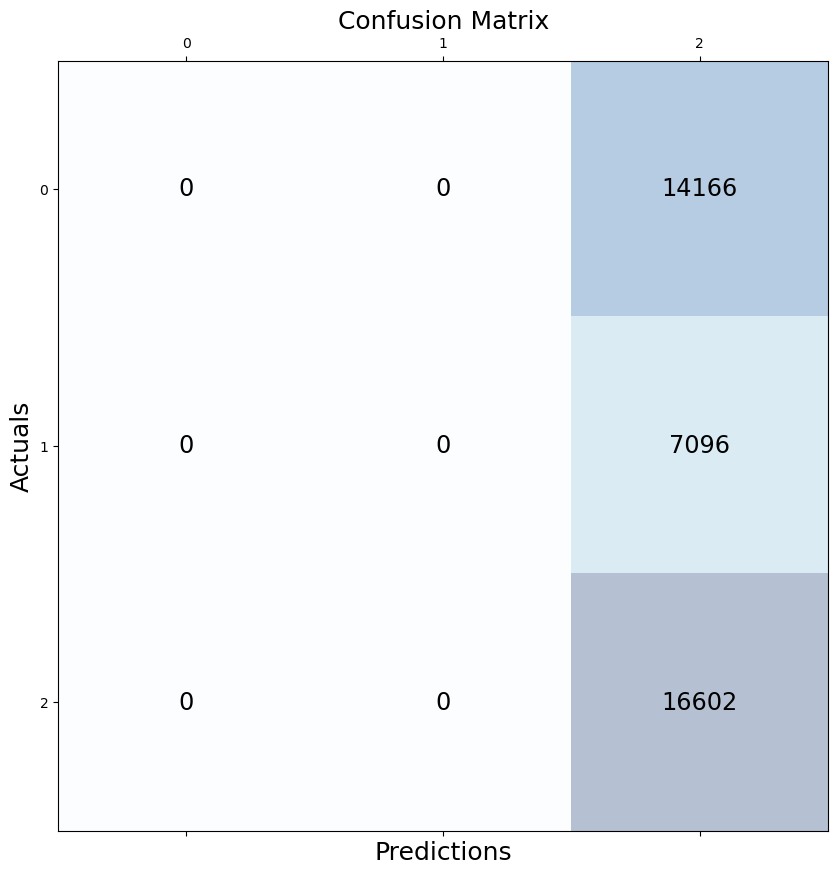

In [16]:





random_cm = np.array([ [0 for i in range(no_of_labels)] for j in range(no_of_labels)])
random_accuracy = compute_random_predictor_accuracy(df_test, no_of_labels, random_cm)
draw_confusion_matrix(random_cm, "random_test") 

allpositive_cm = np.array([ [0 for i in range(no_of_labels)] for j in range(no_of_labels)])
allpositive_accuracy = compute_allpositive_predictor_accuracy(df_test, no_of_labels, allpositive_cm)
draw_confusion_matrix(allpositive_cm, "allpositive_test" )

random_cm = np.array([ [0 for i in range(no_of_labels)] for j in range(no_of_labels)])
compute_random_predictor_accuracy(df, no_of_labels, random_cm)
draw_confusion_matrix(random_cm, "random_training") 

allpositive_cm = np.array([ [0 for i in range(no_of_labels)] for j in range(no_of_labels)])
compute_allpositive_predictor_accuracy(df, no_of_labels, allpositive_cm)
draw_confusion_matrix(allpositive_cm, "allpositive_training" )

print(random_accuracy) 
print(allpositive_accuracy)
print(f"improvement over random baseline is {test_accuracy - random_accuracy}")
print(f"improvement over all positive baseline is {test_accuracy - allpositive_accuracy}")


for all cases, class 2 or "Positive" has the highest value of diagonal entry 
This means that the maximum number of correct predictions have been made for "Positive" label.

In [17]:
# stemming, lematizing and removing stop words
import nltk

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet') 

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [18]:
stopwords = set(stopwords.words('english'))
print(stopwords)

{'herself', 'am', 'between', 'should', 'itself', 'him', 'their', 'she', 'shan', 'and', "hasn't", 'so', 'from', 'more', "aren't", 'only', 'a', 'now', 'just', "wasn't", "hadn't", 'd', 'he', 'when', 'm', 'your', 'our', 'shouldn', 're', "you've", 'where', "that'll", 'theirs', 'each', "weren't", 'be', 'isn', 'they', 've', 'wasn', 'very', 'will', 'those', 'most', 'himself', 'once', 'both', 'mightn', 'here', 'few', 'down', "you're", 'if', 'weren', 'have', "she's", 'any', 'before', 'themselves', 'as', 'there', 'over', 'under', 'ain', "mightn't", 'such', 'because', 'my', 'during', "isn't", 'ourselves', "don't", 'having', 'do', 'll', 'these', 'we', 'don', 'off', 'too', "it's", 'this', 'in', 'o', 'further', "mustn't", 'all', 'her', 'with', 'other', 'doesn', 'hers', 'hadn', "haven't", 'doing', 'while', 'own', "should've", 'them', 'to', 'yours', 'about', 'had', 'the', 'myself', 'its', 'did', 'above', "you'll", "didn't", 'again', 'than', "you'd", 'it', 'at', 'through', 'y', "needn't", 'but', 'wouldn

In [53]:
class Naive_Bayes_2(Naive_Bayes):
    def preprocess(self, text):
        wordlist = text.split(" ") 
        # wordlist = nltk.word_tokenize(text)
        wordlist = [WordNetLemmatizer().lemmatize(word) for word in wordlist]
        wordlist = [word for word in wordlist if word not in stopwords]
        # row_temp = [PorterStemmer().stem(word) for word in row_temp] 
        # stemming
        # wordlist = [PorterStemmer().stem(word) for word in wordlist]
        return wordlist
        
        
        

In [20]:
strong_classifier = Naive_Bayes_2(df, 3) 
strong_classifier.train()
strong_training_accuracy = strong_classifier.compute_accuracy(df) 
print(strong_training_accuracy) 
strong_test_accuracy = strong_classifier.compute_accuracy(df_test) 
print(strong_test_accuracy)


training complete
0.8642510035918023
0.6674764652292742


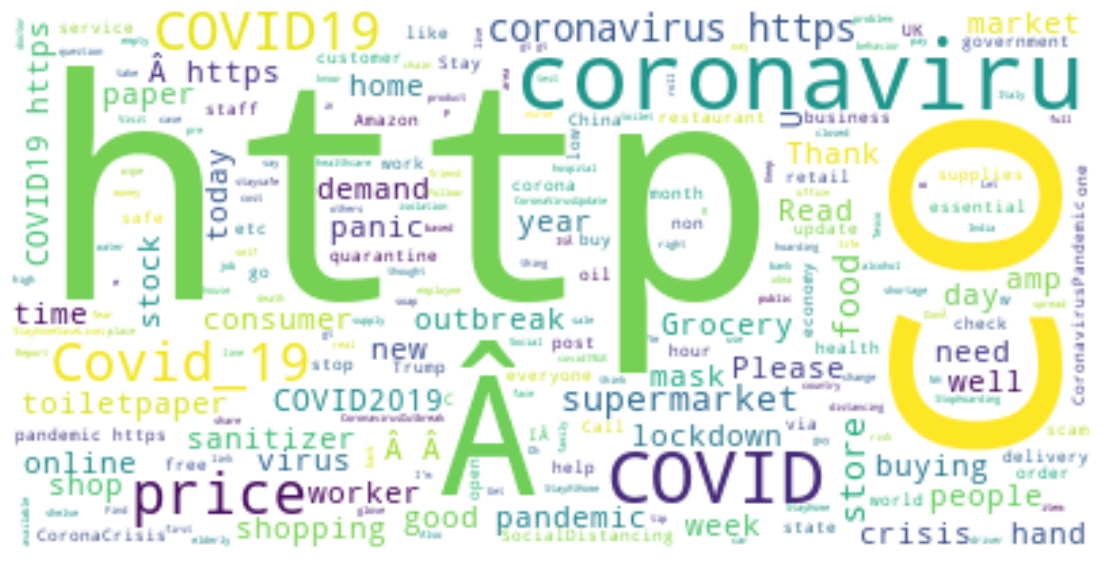

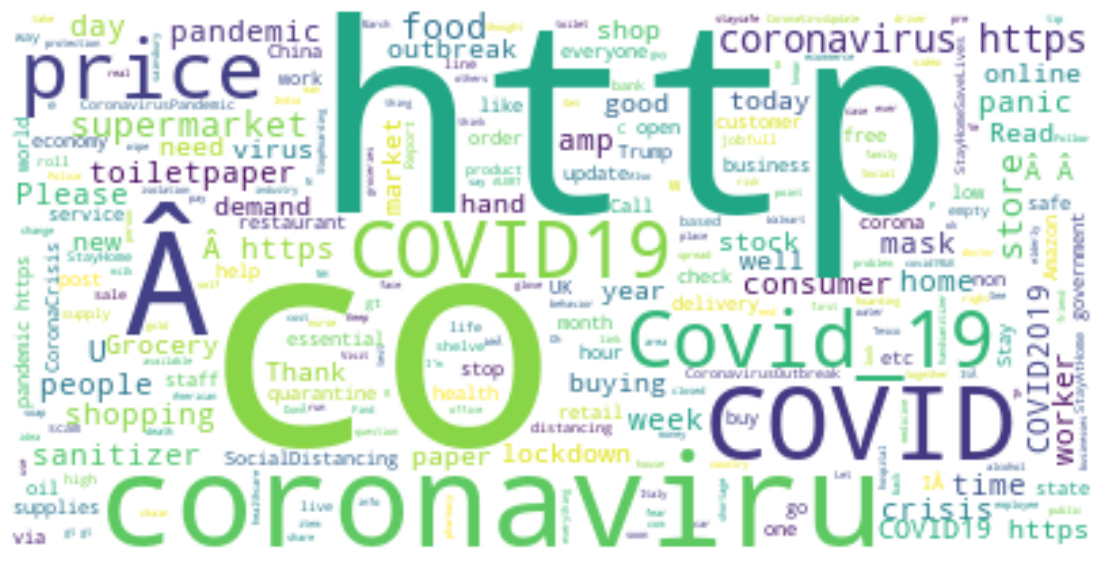

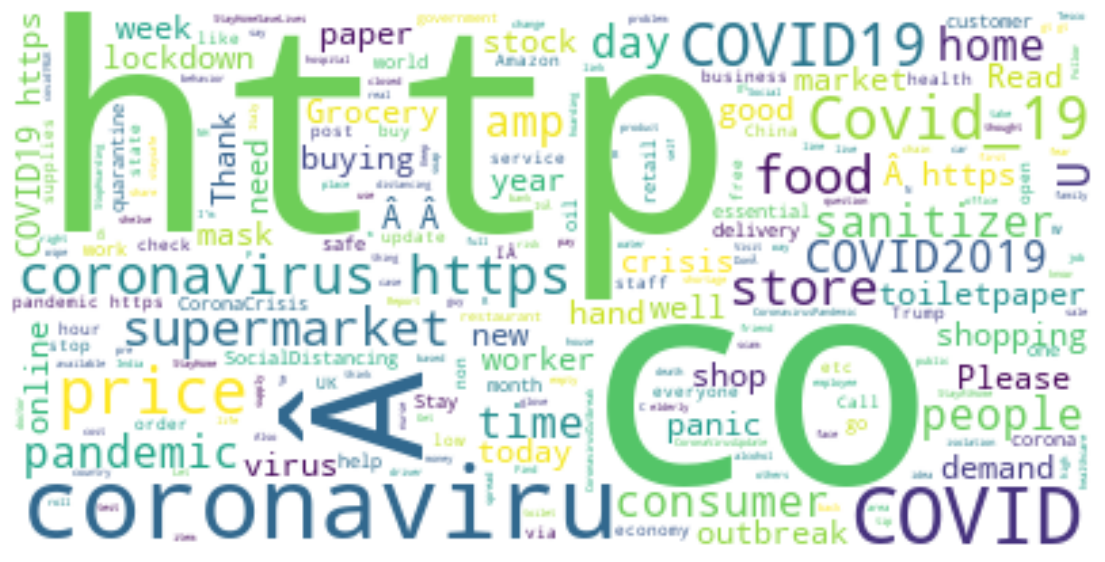

In [21]:
d1 = " ".join(strong_classifier.sets[0])
d2 = " ".join(weak_classifier.sets[0])
# assert(len(d1) == len(d2) )
get_wordcloud( "wordcloud_2_0", " ".join(strong_classifier.sets[0]) ) 
get_wordcloud( "wordcloud_2_1", " ".join(strong_classifier.sets[1]) )
get_wordcloud( "wordcloud_2_2", " ".join(strong_classifier.sets[2]) )

Comments : validation accuracy doesn't increase much, going from 65.05 to 66.50 percent. Thus lematization and stop word removal doesnt improve accuracy much.  This could mean that the dataset does not exhibit strong dependence on inflectional forms of lemmas. 

In [54]:
class Ngrams(Naive_Bayes):
    def __init__(self, df , no_of_labels, n):
        self.df = df 
        self.no_of_labels = no_of_labels
        self.frequencies = dict() 
        self.probabilities, self.log_probabilities  = dict(), dict()
        self.gram_size = n 
        self.SIZE = [0] * n  
        self.SIZES = [[0] * no_of_labels] * n  
        self.sets =  [ [set()] * no_of_labels ] * n  
        self.set_of_words = [set()] * n 
        self.y_prob, self.y_log_prob = [0] * self.no_of_labels, [0] * self.no_of_labels
        
        
    
    def get_grams(self, n, text):
        # returns the ngrams of the text
        wordlist = text.split(" ")
        ngrams = [] 
        size = len(wordlist) 
        for i in range(size- n + 1):
            gram = tuple() 
            for j in range(n):
                gram += (wordlist[i+j],) 
            ngrams.append(gram)
        return ngrams
    
    def preprocess(self, text):
        wordlist = text.split(" ") 
        
        wordlist = [WordNetLemmatizer().lemmatize(word) for word in wordlist]
        wordlist = [word for word in wordlist if word not in stopwords]
        new_text = " ".join(wordlist) 
        ans = [] 
        for i in range(1, self.gram_size + 1):
            ans.extend(self.get_grams(i, new_text)) 
        return ans

    def compute_freqs(self):
        for idx, row in self.df.iterrows():
            if (row["Sentiment"] == "Positive"):
                row["Sentiment"] = 2
            elif (row["Sentiment"] == "Neutral"):
                row["Sentiment"] = 1
            else:
                row["Sentiment"] = 0
            i = row["Sentiment"]

            for gram in row["splitWords"]:
                gram_size = len(gram) 
                # print(f"len of {gram} is {gram_size}")
                self.SIZES[gram_size - 1][i] += 1
                if (gram in self.set_of_words[gram_size - 1]):
                    self.frequencies[gram][i] += 1
                else:
                    self.set_of_words[gram_size - 1].add(gram)
                    self.frequencies[gram] = [0] * self.no_of_labels
                    self.frequencies[gram][i] += 1
                self.sets[gram_size - 1][i].add(gram)

        self.SIZE = [ len(self.set_of_words[i]) for i in range(self.gram_size) ]   
    
    def compute_log_probs(self):
        for i in range(self.gram_size):
            for word in self.set_of_words[i]:
                self.probabilities[word] = [0] * self.no_of_labels
                self.log_probabilities[word] = [0] * self.no_of_labels
                for j in range(self.no_of_labels):
                    self.probabilities[word][j] = (self.frequencies[word][j] + 1) / (self.SIZES[i][j] + self.SIZE[i])
                    self.log_probabilities[word][j] = math.log(self.probabilities[word][j])
        
        total_class_sizes = [ 0 ] * self.no_of_labels 
        
        for i in range(self.gram_size):
            for j in range(self.no_of_labels):
                total_class_sizes[j] += self.SIZES[i][j]

        total_size = sum(total_class_sizes) 
        self.y_prob = [total_class_sizes[i]/total_size for i in range(self.no_of_labels)]
        self.y_log_prob = [math.log(self.y_prob[i]) for i in range(self.no_of_labels)] 
    
    def compute_canonical_log_prob(self, text, label): # ignores P(x) in P(y | x) = P(x|y) * P(y)/ P(x) 
        word_list = self.preprocess(text)
        log_prob = 0 
        for word in word_list:
            # if (word == "") : continue # ignore empty strings 
            size = len(word)
            if (word in self.set_of_words[size - 1]):
                log_prob += self.log_probabilities[word][label] 
            else:
                # log_prob -= math.log((SIZES[label] + SIZE))  # prob is 1 / (SIZES[label] + SIZE)
                continue 
        log_prob += self.y_log_prob[label] 
        return log_prob

    

In [25]:
ngrams_classifier = Ngrams(df, 3, 3) 
ngrams_classifier.train() 
training_accuracy = ngrams_classifier.compute_accuracy(df) 
test_accuracy = ngrams_classifier.compute_accuracy(df_test) 
print(training_accuracy)
print(test_accuracy)
# text = "Learning ML and AI is fun" 
# print(ngrams_classifier.get_grams(3, text))




training complete
0.9928428058313966
0.6562405101730945


In [ ]:
# this is for part e ii), iii)

In [55]:
def domain_adaptation_1(source_df , target_train_df, target_test_df):
    # create an empty df 
    new_df = pd.DataFrame(columns = ["ID", "Tweet", "Sentiment"]) 
    for idx, row in source_df.iterrows():
        # use pd.concat to add a single row to the dataframe


        new_row = pd.DataFrame([{"ID" : row["ID"], "Tweet": row["CoronaTweet"], "Sentiment": row["Sentiment"]}])   
        new_df = pd.concat([new_df, new_row], ignore_index = True) 
        
    new_df = pd.concat([new_df, target_train_df], ignore_index = True) 
    print(new_df) 
    classifier = Naive_Bayes_2(new_df, 3, "Tweet") 
    classifier.train()
    return classifier.compute_accuracy(target_test_df)  

In [56]:
def domain_adaptation_2(target_train_df, target_test_df):
    
    source_df = pd.DataFrame(columns=['ID', 'Sentiment', 'Tweet'])
    return domain_adaptation_1(source_df, target_train_df, target_test_df) 


In [58]:
splits = [1,2,5,10,25,50,100] 
target_dfs = [] 
for i in splits:
    target_dfs.append(pd.read_csv(f'../data/Domain_Adaptation/Twitter_train_{i}.csv')) 

target_test_df = pd.read_csv('../data/Domain_Adaptation/Twitter_validation.csv')  

accuracies_1, accuracies_2 = [], [] 

for target_train_df in target_dfs:
   

    accuracies_1.append(domain_adaptation_1(df, target_train_df, target_test_df))
    accuracies_2.append(domain_adaptation_2(target_train_df, target_test_df)) 

print(accuracies_1)
print(accuracies_2)
 

          ID                                              Tweet Sentiment
0      22979  I see all kinds of academics already whipping ...  Positive
1       9880  @HenrySmithUK can you raise with Boris please ...  Negative
2      35761  It s a confusing odd time for the shopping pub...  Negative
3      37968  Blog Summary: The Impact of COVID-19 on the Ca...  Positive
4      19709  ??????? ??????? ???\r\r\nWaiting in a long Que...   Neutral
...      ...                                                ...       ...
38009    123  Finally played through borderlands 3. The open...  Positive
38010    124  Finally played through borderlands 3. The actu...  Positive
38011    125  Finally played through borderlands 5. The actu...  Positive
38012    132    Come meet one of the lovely Gaming Goddesses .   Positive
38013    133         Meet one of the lovely gambling goddesses.  Positive

[38014 rows x 3 columns]
training complete
      ID                                              Tweet Sentimen

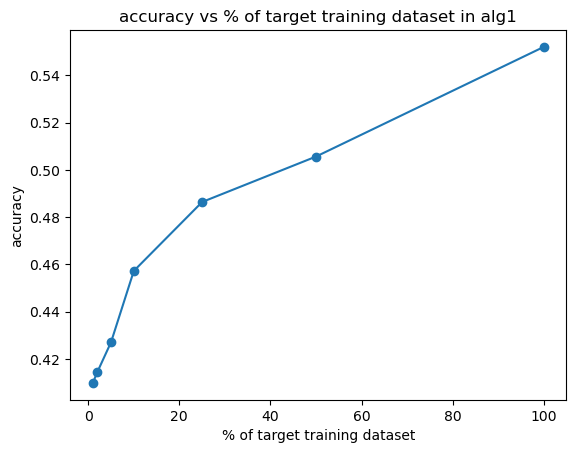

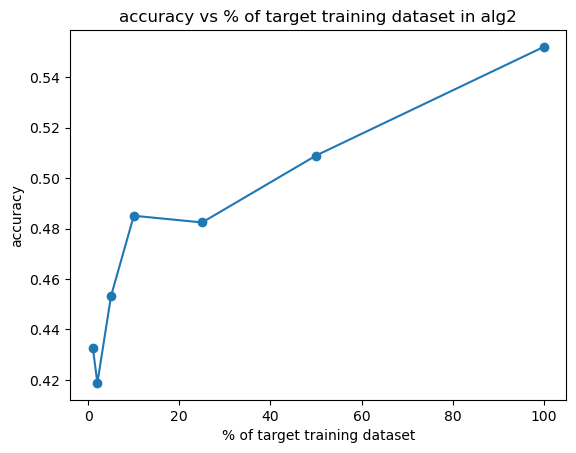

In [59]:
def plot_line(x, y, xlabel, ylabel, title):
    plt.plot(x, y, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    # plt.savefig(f"{name}.png")
    plt.show()

plot_line(splits, accuracies_1, "% of target training dataset", "accuracy", "accuracy vs % of target training dataset in alg1") 
plot_line(splits, accuracies_2, "% of target training dataset", "accuracy", "accuracy vs % of target training dataset in alg2") 
